# Train a OmniPose model from scratch with a pre-trained encoder

This example shows how to use `cellseg_models.pytorch` for training a [OmniPose](https://www.biorxiv.org/content/10.1101/2021.11.03.467199v2) model for instance segmentation. We will be using hugginfaces [accelerate](https://huggingface.co/docs/accelerate/index) library to train the model. **NOTE** This example was executed using `torch==2.0.0`, `accelerate==0.22.0` on a `python==3.9.12` env

**NOTE**: This is a modified version of the CellPose notebook.

In [1]:
# !pip install cellseg-models-pytorch[all]
# !pip install accelerate

In [4]:
import torch
import accelerate
import cellseg_models_pytorch
from platform import python_version

print("torch version:", torch.__version__)
print("accelerate version:", accelerate.__version__)
print("cellseg_models_pytorch version:", cellseg_models_pytorch.__version__)
print("python version:", python_version())

torch version: 2.0.0+cu117
accelerate version: 0.22.0
cellseg_models_pytorch version: 0.1.22
python version: 3.9.12


## Download data

First, we will download some nuclei segmentation data. We will use the [Pannuke](https://jgamper.github.io/PanNukeDataset/) dataset by Gamper et al. The Pannuke dataset is split into three folds. We will use the first and second fold as training data and the third as validation data.

Since we will train the [OmniPose](https://www.biorxiv.org/content/10.1101/2021.11.03.467199v2) model, we need to define the right nuclei instance transformations for training time. For HoVer-Net, we define `"omnipose"` transformation. The `"omnipose"` transforms the labelled instance masks into horizontal and vertical image gradient flows of the nuclei. The model has an output head that regresses these types of masks which will be used for post-processing the nuclei.

Besides the instance mask transformations, we will also set `"blur"` and `"hue_sat"` (hue saturation) transformations and `"minmax"` normalization for the input images.

In [1]:
from pathlib import Path
from cellseg_models_pytorch.datamodules import PannukeDataModule

fold_split = {"fold1": "train", "fold2": "train", "fold3": "valid"}

# NOTE The 'pannuke' directory has to already exist for this to work.
# You can create one in your home folder or just modify the path to your liking,
# The pannuke dataset will be downloaded there.
save_dir = Path.home() / "pannuke"
pannuke_module = PannukeDataModule(
    save_dir=save_dir,
    fold_split=fold_split,
    inst_transforms=["omnipose"],
    img_transforms=["blur", "hue_sat"],
    normalization="percentile",
    batch_size=8,
    num_workers=8,
)

# NOTE: this will take a while to run
pannuke_module.prepare_data() # download and process the pannuke data

Found all folds. Skip downloading.
Found processed pannuke data. If in need of a re-download, please empty the `save_dir` folder.


## Visualize training samples

Here we plot the training image patches with their corresponding instance and type label masks to get a glimpse of what kind of training data Pannuke has.

We also visualize the `omnipose` transformation applied to the instance masks. The `OmniPose`-model is going to regress this transformed auxilliary output which is later used in post-processing to separate overlapping and clumped nuclei. Originally, OmniPose was created to segment bacterial cells that tend to be larger spindle-like cells. It performs better on these types of cells than `CellPose` which typically splits these cells in many objects. `OmniPose` is basically the same model as `CellPose` but instead of regressing `cellpose` transformed instance masks it uses the `omnipose` transformed instance masks.

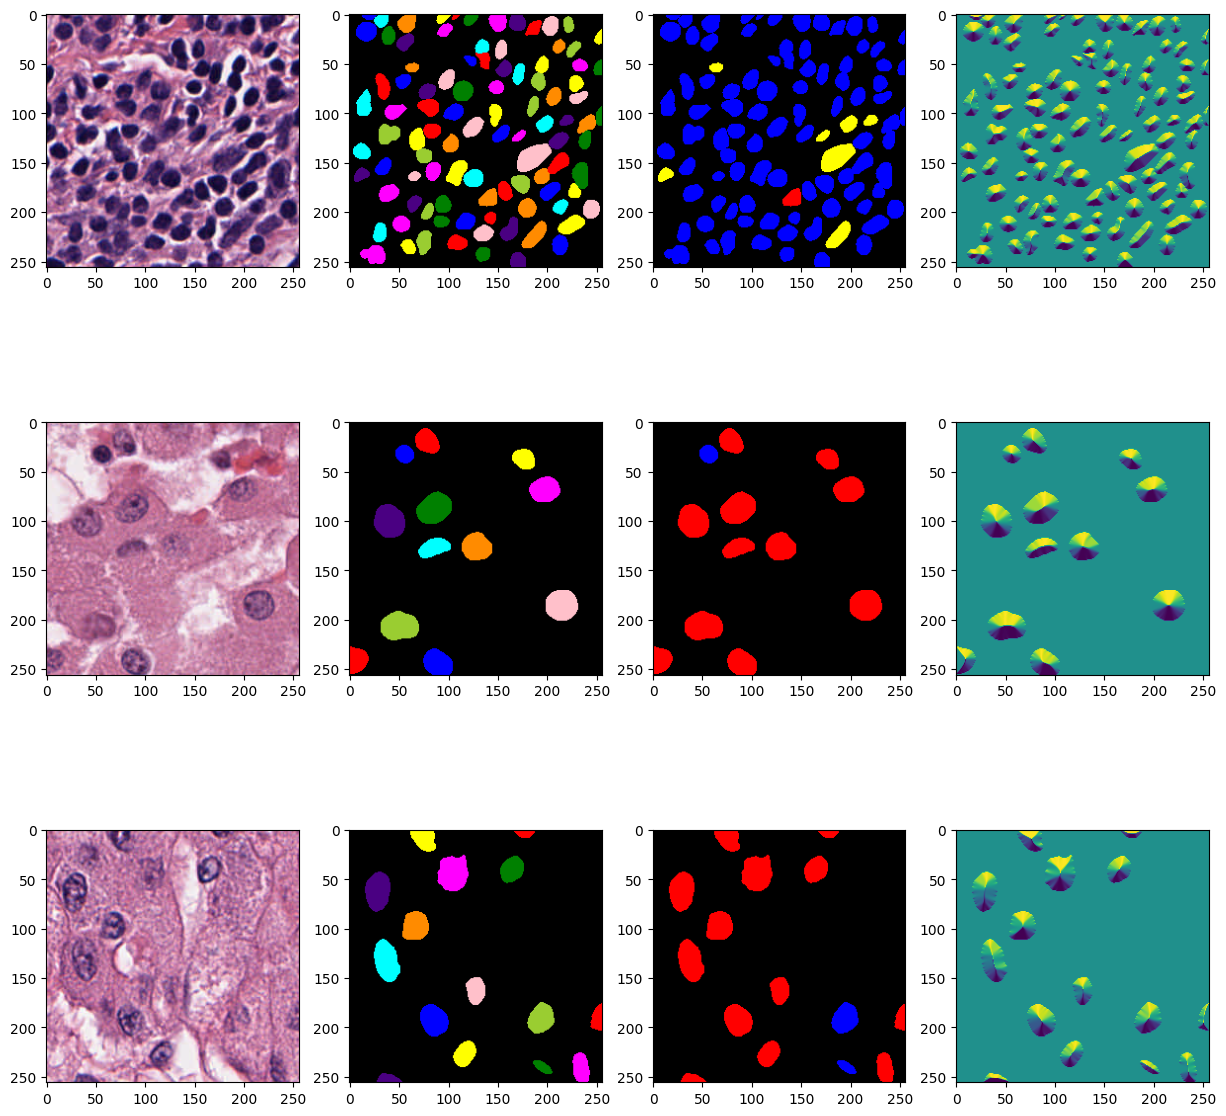

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import label2rgb

# filehandler contains methods to read and write images and masks
from cellseg_models_pytorch.utils import FileHandler
from cellseg_models_pytorch.transforms.functional import gen_omni_flow_maps

img_dir = save_dir / "train" / "images"
mask_dir = save_dir / "train" / "labels"
imgs = sorted(img_dir.glob("*"))
masks = sorted(mask_dir.glob("*"))

ixs = np.random.randint(0, 500, 3)

im1 = FileHandler.read_img(imgs[ixs[0]])
im2 = FileHandler.read_img(imgs[ixs[1]])
im3 = FileHandler.read_img(imgs[ixs[2]])
mask1 = FileHandler.read_mat(masks[ixs[0]], return_all=True)
mask2 = FileHandler.read_mat(masks[ixs[1]], return_all=True)
mask3 = FileHandler.read_mat(masks[ixs[2]], return_all=True)

fig, ax = plt.subplots(3, 4, figsize=(15, 15))
ax = ax.flatten()
ax[0].imshow(im1)
ax[1].imshow(label2rgb(mask1["inst_map"], bg_label=0))
ax[2].imshow(label2rgb(mask1["type_map"], bg_label=0))
ax[3].imshow(gen_omni_flow_maps(mask1["inst_map"])[0])
ax[4].imshow(im2)
ax[5].imshow(label2rgb(mask2["inst_map"], bg_label=0))
ax[6].imshow(label2rgb(mask2["type_map"], bg_label=0))
ax[7].imshow(gen_omni_flow_maps(mask2["inst_map"])[0])
ax[8].imshow(im3)
ax[9].imshow(label2rgb(mask3["inst_map"], bg_label=0))
ax[10].imshow(label2rgb(mask3["type_map"], bg_label=0))
ax[11].imshow(gen_omni_flow_maps(mask3["inst_map"])[0])

## Training with `accelerate`

Next, we will define a a simple `train`-loop wrapper function to train the model. The training logic in the wrapper is built with the [`accelerate`](https://huggingface.co/docs/accelerate/index). It is a convenient way to build training scripts in different types of computing environments. Check out https://huggingface.co/docs/accelerate/index for more.

In the training and validation loops we will have to take into account that the `PannukeDataModule`'s `DataLoader` returns the the inputs and targets in a dictionary like this:
```
{
    "image": torch.Tensor(B, 3, H, W),
    "type": torch.Tensor(B, C, H, W)
    "omnipose": torch.Tensor(B, 2, H, W)
}
```
We will access the `"image"` value in the training loop.
The rest of the masks will be handled automatically in the multi-task-loss function.

### **Training configuration**:

All of these are defined in the `train()`-wrapper function.

**The model**.
First, we will define the CellPose nuclei segmentation model with a `imagenet` pre-trained encoder. Specifically, we will use the `focalnet_small_lrf` backbone for this demonstration. Many more encoders can be used, since these are imported from the `timm` library. There are also support for some transformer based encoders, but these are shown in another notebooks.

**Branch losses**.
For each output of the model, we define a joint-loss function. These losses are summed together during backprop to form a multi-task loss. For the `"omnipose"`branch output we set MAE-loss (Mean Absolute Error) and for the `"type"` (cell type predictions) outputs we will set a joint-loss composed of CE-loss (Cross Entropy) and DICE-loss for both. For the CE-losses, we will also be using [spectral decoupling](https://arxiv.org/abs/2011.09468) to regularize the model. 


**Logging metrics.**
For the nuclei type masks we will monitor Jaccard-index i.e. the mIoU metric during training. The metric is averaged over the class-specific mIoUs. For the cellpose regression branch, we will log the mse-metric. The metrics are from the `torchmetrics` library.

**Optimizer and scheduler.**
The optimizer used here is [AdamW](https://arxiv.org/abs/1711.05101). The learning rate is scheduled with the [CosineAnnealingLR](https://paperswithcode.com/paper/sgdr-stochastic-gradient-descent-with-warm) schedule. Initial lr is set to 0.0003. 

**Other hyperparams.**
We will train for 5 epochs (for demo purposes), so the training will probably not converge to the best possible result but anyways the model will learn something.

In [5]:
import accelerate
from accelerate.utils import set_seed

import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import OneCycleLR
from torchmetrics import JaccardIndex, MeanSquaredError
from tqdm import tqdm

from cellseg_models_pytorch.models import omnipose_base
from cellseg_models_pytorch.losses import SSIM, DiceLoss, CELoss, JointLoss, MultiTaskLoss


# Quick wrapper for MAE loss to make it fit the JointLoss API
class MAELoss(nn.Module):
    def __init__(self, **kwargs) -> None:
        super().__init__()

    def forward(self, yhat: torch.Tensor, target: torch.Tensor, **kwargs) -> torch.Tensor:
        return F.l1_loss(yhat, target, reduction="mean")


# quick train wrapper func
def train():
    set_seed(42)
    
    # we will train with mixed precision
    project_dir = Path.home() / "pannuke" / "omnipose_accelerate"
    accelerator = accelerate.Accelerator(
        mixed_precision="fp16", project_dir=project_dir
    )
    
    # set dataloaders
    pannuke_module.setup()
    train_loader = pannuke_module.train_dataloader()
    val_loader = pannuke_module.val_dataloader()

    # Define the model with the function API. 
    model = omnipose_base(
        enc_name="focalnet_base_srf",
        type_classes=len(pannuke_module.type_classes),
    )

    # Define the multi-task loss function
    branch_losses = {
        "omnipose": MAELoss(),
        "type": JointLoss([CELoss(apply_sd=True), DiceLoss()]),
    }

    multitask_loss = MultiTaskLoss(branch_losses=branch_losses)

    n_epochs = 5 # number of epochs to train for
    
    # optimizer and lr scheduler
    optimizer = torch.optim.AdamW(params=model.parameters(), lr=0.0003)
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=1000, eta_min=0, last_epoch=-1, verbose=False
    )
    
    # training metrics
    type_cls_train_metric = JaccardIndex(
        task="multiclass",
        average="macro",
        num_classes=len(pannuke_module.type_classes),
    ).to(accelerator.device)
    
    omnipose_reg_train_metric = MeanSquaredError().to(accelerator.device)
    
    # validation metrics
    type_cls_val_metric = JaccardIndex(
        task="multiclass",
        average="macro",
        num_classes=len(pannuke_module.type_classes),
    ).to(accelerator.device)
    
    omnipose_reg_val_metric = MeanSquaredError().to(accelerator.device)
        
    # prepare the model, optimizer, and dataloaders for accelerate
    model, optimizer, train_loader, val_loader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_loader, val_loader, lr_scheduler
    )

    # metric values for plotting
    train_mious = []
    train_mses = []
    val_mious = []
    val_mses = []
    
    # training loop
    for epoch in range(n_epochs):
        model.train()
        total_loss = 0
        
        with tqdm(train_loader, unit="batch") as loader:
            loader.set_description(f"Epoch: {epoch}")
            for batch in loader:
                # run forward pass and compute loss
                soft_masks = model(batch["image"])
                targets = {k: val for k, val in batch.items() if k != "image"}
                loss = multitask_loss(soft_masks, targets)
                
                # compute total loss for tracking
                total_loss += loss.detach().float()
                batch_miou = type_cls_train_metric(soft_masks["type"], targets["type"])
                batch_mse = omnipose_reg_train_metric(soft_masks["omnipose"], targets["omnipose"])
                
                # round metrics to 4 decimal places for progress bar logging
                batch_miou = round(batch_miou.item(), 4)
                batch_mse = round(batch_mse.item(), 4)
                batch_loss = round(loss.item(), 4)
                
                # log loss and metrics in progress bar
                s = f"batch loss: {batch_loss}, batch miou: {batch_miou}, batch mse: {batch_mse}"
                loader.set_postfix_str(s)
                
                # run backward pass
                accelerator.backward(loss)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()
                
        # metric on all batches using custom accumulation
        miou = type_cls_train_metric.compute()
        mse = omnipose_reg_train_metric.compute()
        train_mious.append(miou)
        train_mses.append(mse)
        accelerator.print(f"total loss on all train data: {round(total_loss.item(), 4)}")
        accelerator.print(f"type mIoU on all train data: {round(miou.item(), 4)}")
        accelerator.print(f"omnipose mse on all train data: {round(mse.item(), 4)}")

        # Reseting internal state such that metrics are ready for new data
        type_cls_train_metric.reset()
        omnipose_reg_train_metric.reset()
        
        # save model checkpoint
        accelerator.save_model(model, project_dir)
            
        # validation loop
        model.eval()
        with tqdm(val_loader, unit="batch") as loader:
            loader.set_description(f"Validation epoch")
            for batch in loader:
                with torch.no_grad():
                    soft_masks = model(batch["image"])
                    targets = {k: val for k, val in batch.items() if k != "image"}
                    
                    loss = multitask_loss(soft_masks, targets)
                
                    # compute total loss for tracking
                    total_loss += loss.detach().float()
                    batch_miou = type_cls_val_metric(soft_masks["type"], targets["type"])
                    batch_mse = omnipose_reg_val_metric(soft_masks["omnipose"], targets["omnipose"])
                    
                    # round metrics to 4 decimal places for progress bar logging
                    batch_miou = round(batch_miou.item(), 4)
                    batch_mse = round(batch_mse.item(), 4)
                    batch_loss = round(loss.item(), 4)
                    
                    # log loss and metrics in progress bar
                    s = f"val loss: {batch_loss}, val batch miou: {batch_miou}, val batch mse: {batch_mse}"
                    loader.set_postfix_str(s)

        # metric on all batches using custom accumulation
        miou = type_cls_val_metric.compute()
        mse = omnipose_reg_val_metric.compute()
        val_mious.append(miou)
        val_mses.append(mse)
        accelerator.print(f"total val loss on all val data: {round(total_loss.item(), 4)}")
        accelerator.print(f"val type mIoU on all val data: {round(miou.item(), 4)}")
        accelerator.print(f"val omnipose mse on all val data: {round(mse.item(), 4)}")
        
        # Reseting internal state such that metrics are ready for new data
        type_cls_val_metric.reset()
        omnipose_reg_val_metric.reset()
        
    fig, ax = type_cls_val_metric.plot(val_mious)
    plt.show()    

Launching training on one GPU.


Epoch: 0: 100%|██████████| 648/648 [03:22<00:00,  3.20batch/s, batch loss: 0.4372, batch miou: 0.482, batch mse: 0.0344] 


total loss on all train data: 428.9994
type mIoU on all train data: 0.3567
omnipose mse on all train data: 0.0821


Validation epoch: 100%|██████████| 341/341 [01:41<00:00,  3.34batch/s, val loss: 0.4204, val batch miou: 0.6177, val batch mse: 0.0499]


total val loss on all val data: 597.6337
val type mIoU on all val data: 0.4249
val omnipose mse on all val data: 0.0452


Epoch: 1: 100%|██████████| 648/648 [02:52<00:00,  3.75batch/s, batch loss: 0.28, batch miou: 0.5895, batch mse: 0.0236]  


total loss on all train data: 290.4487
type mIoU on all train data: 0.4896
omnipose mse on all train data: 0.043


Validation epoch: 100%|██████████| 341/341 [01:19<00:00,  4.31batch/s, val loss: 0.398, val batch miou: 0.6571, val batch mse: 0.0483] 


total val loss on all val data: 442.3772
val type mIoU on all val data: 0.4921
val omnipose mse on all val data: 0.0426


Epoch: 2: 100%|██████████| 648/648 [02:50<00:00,  3.81batch/s, batch loss: 0.4956, batch miou: 0.2887, batch mse: 0.0315]


total loss on all train data: 310.5264
type mIoU on all train data: 0.4519
omnipose mse on all train data: 0.0426


Validation epoch: 100%|██████████| 341/341 [01:20<00:00,  4.23batch/s, val loss: 0.4104, val batch miou: 0.4719, val batch mse: 0.0452]


total val loss on all val data: 479.6977
val type mIoU on all val data: 0.4439
val omnipose mse on all val data: 0.0423


Epoch: 3: 100%|██████████| 648/648 [02:49<00:00,  3.83batch/s, batch loss: 0.5543, batch miou: 0.4239, batch mse: 0.0601]


total loss on all train data: 282.0023
type mIoU on all train data: 0.4861
omnipose mse on all train data: 0.0383


Validation epoch: 100%|██████████| 341/341 [01:19<00:00,  4.32batch/s, val loss: 0.3471, val batch miou: 0.663, val batch mse: 0.0374] 


total val loss on all val data: 422.4279
val type mIoU on all val data: 0.5157
val omnipose mse on all val data: 0.0361


Epoch: 4: 100%|██████████| 648/648 [02:49<00:00,  3.82batch/s, batch loss: 0.3935, batch miou: 0.2096, batch mse: 0.0098]


total loss on all train data: 233.9926
type mIoU on all train data: 0.5544
omnipose mse on all train data: 0.0343


Validation epoch: 100%|██████████| 341/341 [01:19<00:00,  4.26batch/s, val loss: 0.3515, val batch miou: 0.654, val batch mse: 0.0395] 


total val loss on all val data: 368.8082
val type mIoU on all val data: 0.5243
val omnipose mse on all val data: 0.0361


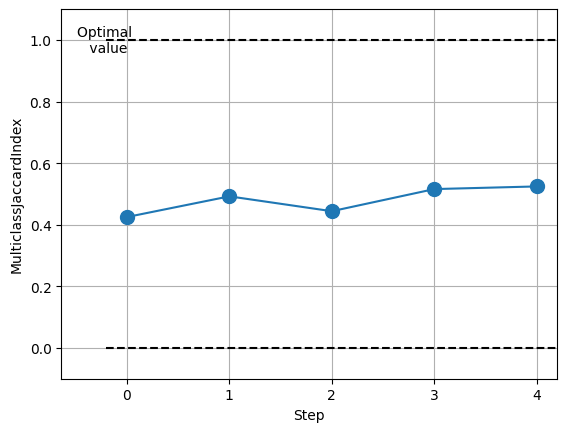

In [8]:
from accelerate import notebook_launcher

notebook_launcher(train, num_processes=1, mixed_precision="fp16")

# Model outputs

Next we will visualize what kind of outputs the model is able to produce after 5 epochs of training. 

Especially, we will look at the `omnipose`, and the `type` maps.

- The `omnipose` maps on the other hand are used as the input for `omnipose`-post-processing pipeline that is used to separate clumped and overlapping nuclei from each other to produce an instance segmentation map. 
- The `type` maps are used to classify the nuclei instances into the `pannuke` cell type classes. Note that the type maps are also post-processed with a majority-voting approach in the post-processing pipeline since typically there is a mixture of different classes within a predicted nuclei as you will see from the type maps below. 

In [6]:
# The model state dict was saved in the project_dir
state_dict = torch.load(Path.home() / "pannuke/omnipose_accelerate/pytorch_model.bin")

# init the model with the same params as before
model = omnipose_base(
    enc_name="focalnet_base_srf",
    type_classes=len(pannuke_module.type_classes),
)

# load the trained weights
model.load_state_dict(state_dict)

<All keys matched successfully>

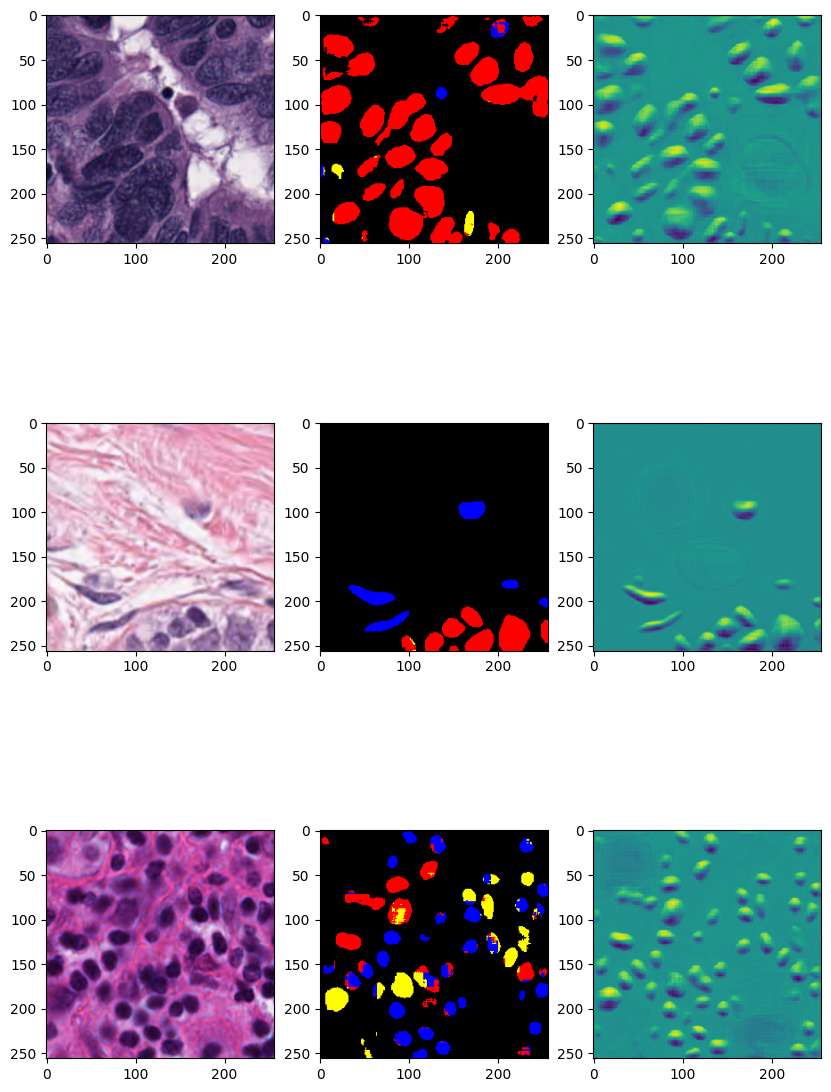

In [9]:
from cellseg_models_pytorch.utils import percentile_normalize

img_dir = save_dir / "valid" / "images"
mask_dir = save_dir / "valid" / "labels"
imgs = sorted(img_dir.glob("*"))
masks = sorted(mask_dir.glob("*"))

ixs = np.random.randint(0, 500, 3)
im1 = FileHandler.read_img(imgs[ixs[0]])
im2 = FileHandler.read_img(imgs[ixs[1]])
im3 = FileHandler.read_img(imgs[ixs[2]])
img1 = torch.from_numpy(percentile_normalize(im1)).permute(2, 0, 1).unsqueeze(0).float()
img2 = torch.from_numpy(percentile_normalize(im2)).permute(2, 0, 1).unsqueeze(0).float()
img3 = torch.from_numpy(percentile_normalize(im3)).permute(2, 0, 1).unsqueeze(0).float()

pred1 = model(img1)
pred2 = model(img2)
pred3 = model(img3)

fig, ax = plt.subplots(3, 3, figsize=(10, 15))
ax = ax.flatten()
ax[0].imshow(im1)
ax[1].imshow(label2rgb(np.argmax(pred1["type"].squeeze().detach().numpy(), axis=0), bg_label=0))
ax[2].imshow(pred1["omnipose"].squeeze().detach().numpy()[0])
ax[3].imshow(im2)
ax[4].imshow(label2rgb(np.argmax(pred2["type"].squeeze().detach().numpy(), axis=0), bg_label=0))
ax[5].imshow(pred2["omnipose"].squeeze().detach().numpy()[0])
ax[6].imshow(im3)
ax[7].imshow(label2rgb(np.argmax(pred3["type"].squeeze().detach().numpy(), axis=0), bg_label=0))
ax[8].imshow(pred3["omnipose"].squeeze().detach().numpy()[0])

In [11]:
from cellseg_models_pytorch.inference import ResizeInferer

inferer = ResizeInferer(
    model=model,
    input_path=save_dir / "valid" / "images",
    out_activations={"omnipose": None, "type": "softmax"},
    out_boundary_weights={"omnipose":  False, "type": False},
    resize=(256, 256), # Not actually resizing anything,
    instance_postproc="omnipose",
    save_intermediate=True, # save intermediate soft masks for visualization
    batch_size=8,
    n_images=50, # Use only the 50 first images of the folder
    normalization="percentile",
)
inferer.infer()

  0%|          | 0/7 [00:00<?, ?batch/s]

Running inference: 100%|██████████| 7/7 [00:04<00:00,  1.70batch/s, post-processing]


**Let's plot some results**

With only 5 epochs of training, we can get moderate results by just eyeballing. 

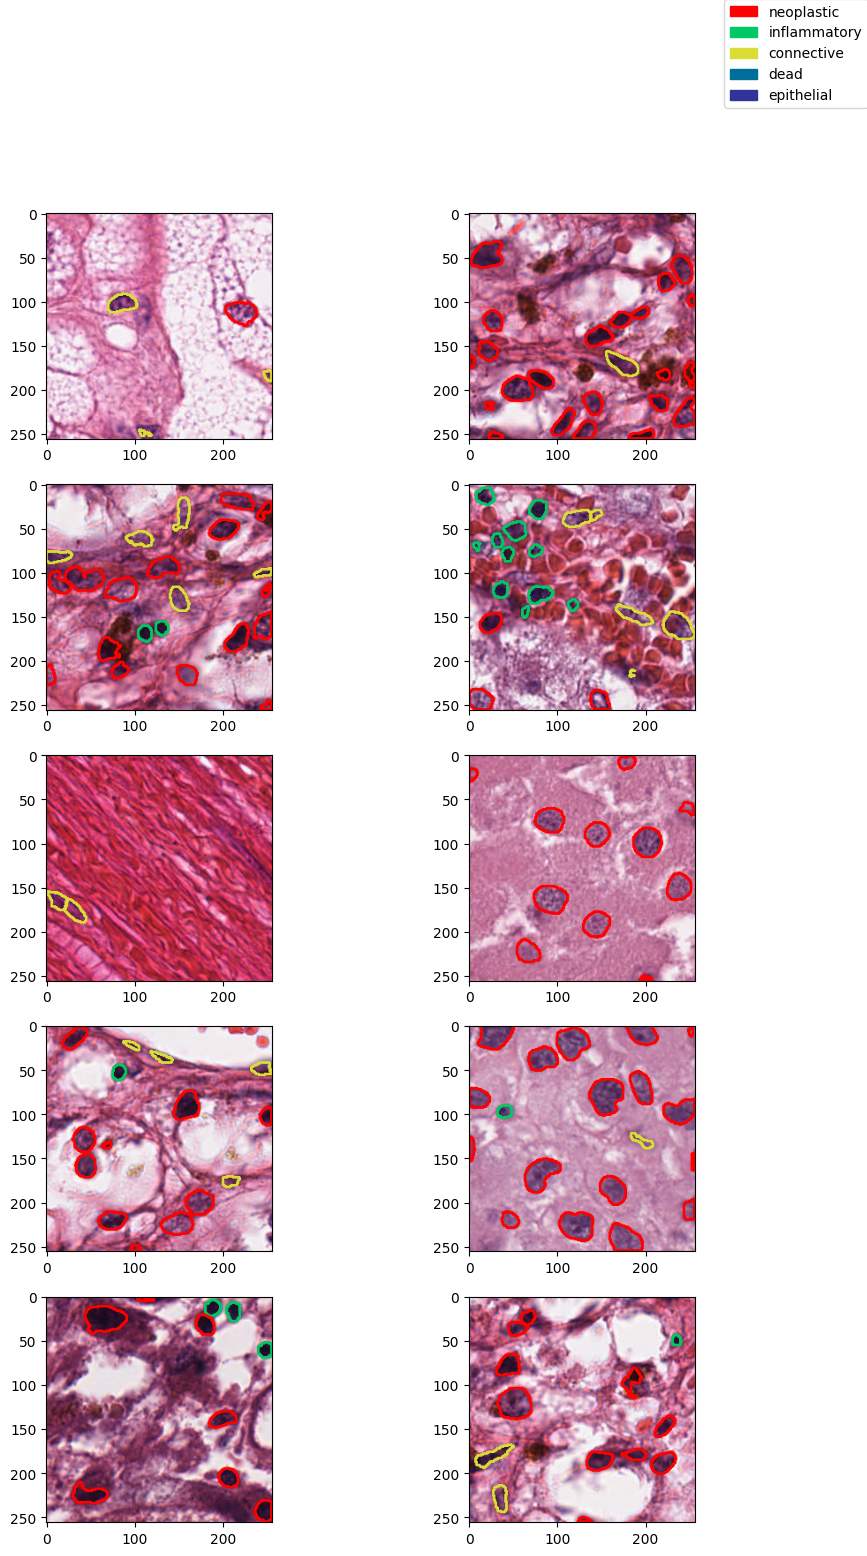

In [12]:
import numpy as np
from cellseg_models_pytorch.utils import draw_thing_contours
import matplotlib.patches as mpatches


fig, ax = plt.subplots(5, 2, figsize=(10, 17))
ax = ax.flatten()
ixs = np.random.choice(50, 10, replace=False)

samples = list(inferer.out_masks.keys())
for i, ix in enumerate(ixs):
    masks = inferer.out_masks[samples[ix]]
    inter = inferer.soft_masks[samples[ix]]

    img_path = save_dir / "valid" / f"images/{samples[ix]}.png"
    img = FileHandler.read_img(img_path)
    cont = draw_thing_contours(masks["inst"], img, masks["type"])
    ax[i].imshow(cont)
    
# add legend 
cmap = {
    1: (255.0/255, 0.0, 0.0),
    2: (0.0, 200.0/255, 100.0/255),
    3: (220.0/255, 220.0/255, 55.0/255),
    4: (0.0, 110.0/255, 155.0/255),
    5: (50.0/255, 50.0/255, 155.0/255),
}
labels = {k: j for j, k in pannuke_module.type_classes.items()}
patches =[mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap] 
fig.legend(handles=patches, loc=1, borderaxespad=0)
